# STEP 2: Finetuning LernnaviBERT on MCQs correct answer prediction

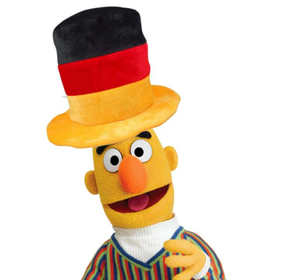

[Source of the image: https://huggingface.co/bert-base-german-cased]

In order to transform a pretrained GermanBERT model in a model able to predict the students’ answers to Multiple Choice Questions (MCQs), we decided to follow a pipeline made of three steps:
1. Finetuning GermanBERT on language modelling considering the Lernnavi dataset. The finetuned model will be renamed "LernnaviBERT" for clarity;
2. Finetuning LernnaviBERT to predict the correct answers to MCQs;
3. Further finetuning the model on the final downstream task, that is the prediction of the answers of a given student to MCQs, taking into account the embedding of the student.

In this notebook, we will perform the second step, that is finetuning LernnaviBERT to predict the correct answer to MCQs. In particular, we will start by introducing some models based on LernnaviBERT, and we will first finetune them on a training set and verify whether they generalize well on a test set. Then, we will train the models on the whole MCQs dataset since we would like our models to know the correct answers to all the MCQs. In this way, we are sure that a failure to predict the answer of a student to an MCQ does not stem from the model not knowing which answer is correct.

## Theoretical motivation

As stated previously, our final goal is creating a model able to predict the answer of a student to a MCQ given the question, the possible answers and some relevant information concerning the student (in the form of an embedding). To reach this goal, we wanted the model to know the correct answers to all the MCQs present in the dataset before attempting to predict the answers of the students. Indeed, we would like the model to exploit the knowledge of the correct answer to a MCQ to predict the student's answers more accurately. For example, if the model knows that a student is answering correctly to all the questions concerning a particular topic, it may decide to predict that the student will answer correctly to a question on that topic, and would therefore need to know which is the correct answer.

We, therefore, finetune two models which have been built upon LernnaviBERT to predict the correct answers to MCQs. We are interested in exploring two settings:
- To verify if the model learns to generalize, that is whether it is able to answer correctly to MCQs after seeing some correct answers to MCQs, we train the model on a training set and evaluate it on a test set.
- To verify whether the model remembers the correct answers to the MCQs it has seen during training, we train the model on the complete dataset and we evaluate it on the same dataset.

It should be noted that, in the next step, we will consider the model trained on the complete dataset. This, however, does not risk to introduce data leakage, as our final goal will be to predict the answer of students to MCQs, not the correct answer. Moreover, we would like the model to learn the correct answers to all MCQs, and exploit this information while predicting the answers given by the students.

## STEP 2

We then define a set of variables that we will need during the finetuning process.

In [1]:
train_ratio = 0.8
splitting_tolerance = 0.02
batch_size = 16
max_gradient_norm = 1.0
warmup_p = 0.3
learning_rate = 1.75e-5

BASE_DATA_DIR = "../../data"
QNA_DATA_DIR = f"{BASE_DATA_DIR}/lernnavi/qna"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

Then, we import all the packages which are necessary to run the notebook.

In [2]:
import pickle
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from dataset_train_eval_extensions import QuestionsDatasetCorrect, train
import torch
from transformers import BertModel, AutoTokenizer, AutoConfig
import numpy as np 
import random
from huggingface_hub import notebook_login

At this point, we fix the random seed for reproducibility purposes. It should be noted, in any case, that the randomness is not completely removed, and the results may vary from run to run.

In [3]:
seed = int(0)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print('Random seed (for reproducibility): ', seed)

Random seed (for reproducibility):  0


We load the dataset containing all the Lernnavi MCQs (questions and possible answers), and the correct answers for the various MCQs.

In [4]:
with open(f'{QNA_DATA_DIR}/MULTIPLE_CHOICE_german.pkl', 'rb') as file:
    data_correct = pickle.load(file)

We then preprocess the dataset containing the MCQs and the correct answers by selecting which columns and rows to keep and removing the HTML tags.

In [5]:
# Step 1: Select which columns to keep
data_correct = data_correct[["question", "choices", "correct"]].reset_index(drop = True)

# Step 2: Select which rows to keep
data_correct = data_correct[data_correct["choices"].str.len() > 0]

# Step 3: Remove HTML tags
data_correct["question"] = data_correct["question"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
data_correct["choices"] = data_correct["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])

/tmp/ipykernel_4180/435354947.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data_correct["choices"] = data_correct["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])


At this point, we split the dataset in a training dataset and a validation/test dataset. Since each MCQ is present more than once in the dataset (as we have a datapoint for each student's answer) and we would like to test the model on new MCQs to verify whether it has learnt how to correctly answers MCQs, we will perform the split ensuring that each individual MCQs will be present only in the training set or in the test set. In other words, all the instances of a given MCQ will be only in one of the two datasets that we will create.

In [6]:
# Splitting by question
unique_questions = data_correct['question'].unique()
discrepancy = 1.0
data_train_correct = pd.DataFrame()
data_val_correct = pd.DataFrame()
add_seed = 0
# Splitting until the actual train ratio is close enough to the desired one (within splitting_tolerance)
while abs(discrepancy) > splitting_tolerance:
    # Splitting the unique questions
    train_questions_correct, val_questions_correct = train_test_split(unique_questions, train_size = train_ratio, random_state = seed + add_seed)
    # Determining which rows are in the train and validation sets
    data_train_correct = data_correct[data_correct['question'].isin(train_questions_correct)]
    data_val_correct = data_correct[data_correct['question'].isin(val_questions_correct)]
    # Calculating the actual train ratio
    total_rows = len(data_train_correct) + len(data_val_correct)
    actual_train_ratio = len(data_train_correct) / total_rows
    # Calculating the discrepancy
    discrepancy = actual_train_ratio - train_ratio
    add_seed = add_seed + 1
print(f"Actual train ratio: {actual_train_ratio}")

print(f"Training set size: {len(data_train_correct)}")
print(f"Validation set size: {len(data_val_correct)}")

Actual train ratio: 0.8004762973311425
Training set size: 110585
Validation set size: 27564


As indicated in the previous milestone, we decided to frame the MCQs prediction problem as a binary classification problem. More in detail, we split each datapoint into multiple datapoints, each of them containing the question and one of the possible answers. The objective of the model is to predict 1 if the possible answer is correct (or, in the next step, if the student selected that possible answer) and to predict 0 if the possible answer is not correct (or, in the next step, if the student did not select that possible answer).

We now define the complete models, which include a classifier head (two linear layers with a ReLU activation in between) so that the model can predict whether each of the possible answers is correct or not. It should be noted that each of the models is based on LernnaviBERT, which we download from the HuggingFace hub. Furthermore, we also finetune a baseline model, which do not contain the embeddings (the baseline will be useful for the next step).

In [10]:
model_name = "tommymarto/LernnaviBERT"
config = AutoConfig.from_pretrained(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layer_size = 256 # Size of the hidden layer in the classifier
embedding_size = 384 # Size of the student embedding

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Baseline model, based on BertModel (baseline model without embeddings)
import torch.nn as nn
from dataset_train_eval_extensions import metrics
from tqdm import tqdm

class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, *args):
        return torch.tensor([[0.]] * args[0].shape[0]).cuda()

    @property
    def classifier(self):
        return DummyModel()

model = DummyModel()

We now create the training dataset and the validation datasets, starting from the split previously done. In this case, we are interested in training the models on the training dataset, and to evaluate them on the validation dataset. In this way, we are able to verify whether the models are able to generalize the prediction to MCQs which they did not see during the training process.

In [8]:
# Training dataset for correct answers
train_dataset_correct = QuestionsDatasetCorrect(tokenizer, data_train_correct, embedding_size)
# Validation dataset for correct answers
dev_dataset_correct = QuestionsDatasetCorrect(tokenizer, data_val_correct, embedding_size)

110585it [02:14, 819.86it/s] 
27564it [00:27, 1017.48it/s]


In [11]:
val_data=dev_dataset_correct
train_weights=train_dataset_correct.weights

eval_loss = 0
eval_step = 0
batch_labels = []
batch_preds = []
eval_dataloader = torch.utils.data.DataLoader(val_data, sampler=torch.utils.data.SequentialSampler(val_data), batch_size=batch_size, collate_fn=val_data.collate_batch)

# Loss function (with weights to balance the classes)
pos_weight_value = (train_weights[1] / train_weights[0])
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)

model.eval()

for batch in tqdm(eval_dataloader, desc="Evaluation"):
    eval_step = eval_step + 1
    with torch.no_grad():
        ids, labels, student_embeddings, student_features = tuple(input_t.to(device) for input_t in batch)
        logits = model(ids)
        loss = criterion(logits.squeeze(1), labels)
        eval_loss = eval_loss + loss.mean().item()
        batch_labels.append(labels.detach().cpu().numpy())
        batch_preds.append((logits.detach().cpu().numpy() > 0.5).astype(int))
pred_labels = np.concatenate(batch_preds)

eval_loss = eval_loss / eval_step
true_labels = list(np.concatenate(batch_labels))
acc_score, f1_0, f1_1, con_matrix, mcc = metrics(pred_labels, true_labels)

print(acc_score, f1_0, f1_1, con_matrix, mcc)

Evaluation:   0%|          | 11/6573 [00:00<01:07, 97.74it/s]

Evaluation: 100%|██████████| 6573/6573 [01:09<00:00, 94.58it/s] 


0.6057459130980571 0.7544729314357799 0.0 [[63696     0]
 [41457     0]] 0.0
